In [1]:
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm

In [3]:
test = pd.read_csv('./test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11776968 entries, 0 to 11776967
Data columns (total 3 columns):
id          int64
node1_id    int64
node2_id    int64
dtypes: int64(3)
memory usage: 269.6 MB


In [5]:
gc.collect()

587

In [6]:
user_features = pd.read_csv('./train/user_features.csv')
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8264276 entries, 0 to 8264275
Data columns (total 14 columns):
node_id    int64
f1         int64
f2         int64
f3         int64
f4         int64
f5         int64
f6         int64
f7         int64
f8         int64
f9         int64
f10        int64
f11        int64
f12        int64
f13        int64
dtypes: int64(14)
memory usage: 882.7 MB


In [10]:
base = test.merge(user_features, left_on='node1_id', right_on='node_id', how = 'left')
base = base.merge(user_features, left_on='node2_id', right_on='node_id', how = 'left')
base = base.drop(columns=['node_id_x', 'node_id_y','node1_id','node2_id'])
idvar = base.id
base = base.drop(columns=['id'])
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11776968 entries, 0 to 11776967
Data columns (total 26 columns):
f1_x     int64
f2_x     int64
f3_x     int64
f4_x     int64
f5_x     int64
f6_x     int64
f7_x     int64
f8_x     int64
f9_x     int64
f10_x    int64
f11_x    int64
f12_x    int64
f13_x    int64
f1_y     int64
f2_y     int64
f3_y     int64
f4_y     int64
f5_y     int64
f6_y     int64
f7_y     int64
f8_y     int64
f9_y     int64
f10_y    int64
f11_y    int64
f12_y    int64
f13_y    int64
dtypes: int64(26)
memory usage: 2.4 GB


In [11]:
from sklearn.externals import joblib
sc = joblib.load('./scaler.pkl') 

In [12]:
base = sc.fit_transform(base)
base.shape

(11776968, 26)

In [8]:
gc.collect()

7

In [14]:
import tensorflow as tf
from keras import backend as K

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [16]:
from keras.models import load_model
nn = load_model('./hike_recommender_04-0.11.hdf5', custom_objects={'auc': auc})

In [19]:
train = pd.read_csv('./train/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70661802 entries, 0 to 70661801
Data columns (total 3 columns):
node1_id    int64
node2_id    int64
is_chat     int64
dtypes: int64(3)
memory usage: 1.6 GB


In [26]:
train[train.node1_id==train.node2_id].is_chat.value_counts()

0    902302
1      1186
Name: is_chat, dtype: int64

In [27]:
preds = nn.predict([base[:, 0:13], base[:, 13:]], verbose=1)

11776968/11776968 [==============================] - 193s 16us/step


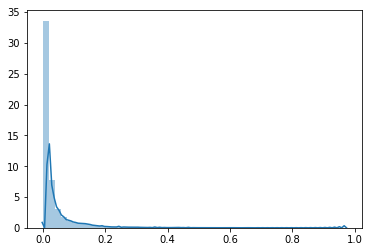

In [29]:
import seaborn as sns 
%matplotlib inline
sns.distplot(preds)

/anaconda3/envs/devenv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


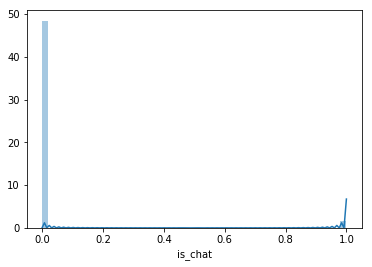

In [30]:
sns.distplot(train.is_chat)

In [36]:
submission = pd.DataFrame({'id':test.id, 'is_chat':preds[:,0]})
submission.head()

,id,is_chat
0,1,0.028918
1,2,0.004894
2,3,0.008384
3,4,0.004847
4,5,0.029235


In [37]:
submission.to_csv('./submission.csv', index = False)